In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [17]:
data = pd.read_csv('../data/student-por.csv')

In [18]:
Y = data[['G1', 'G2', 'G3']].sum(axis=1)
X = data.drop(['G1', 'G2', 'G3'], axis=1)
X = (X-X.min())/(X.max()-X.min())
Y = Y.apply(lambda x: 1 if x > 36 else 0)

In [19]:
random_state = 9527

pca_1d = PCA(15, random_state=random_state)
L_sk = pca_1d.fit_transform(X)
print(pca_1d.explained_variance_ratio_)
print('L_sk.shape:', L_sk.shape)
print('L_sk:', L_sk[:, :4])


[0.11397246 0.09177979 0.07526411 0.06875526 0.06262613 0.06071489
 0.0498503  0.04426735 0.04270601 0.03919675 0.03729149 0.03354056
 0.03132639 0.02914474 0.02475502]
L_sk.shape: (649, 15)
L_sk: [[ 0.15694681 -0.55898024 -0.78419413  0.29488769]
 [ 0.06706346 -0.76053984 -0.4263281  -0.12175133]
 [-0.04446017 -0.25665235 -0.91904688  0.45874699]
 ...
 [ 0.77200794 -0.02178038 -0.02007369  0.04254561]
 [ 0.20514191  1.05791171 -0.87295291  0.34058107]
 [ 0.61510887  1.2109193  -0.7253179  -0.10288083]]


In [20]:
%%time
log_data = []
best_report= None
curr_best_model = None
best_f1 = 0
best_i = -1
for i in range(20, 80):
    X_train, X_test, y_train, y_test = train_test_split(L_sk, Y, test_size=i / 100, random_state=42)
    lr = LogisticRegression()
    model = lr.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate additional metrics if needed (e.g., precision, recall)

    if f1 > best_f1 and 80 > i > 20 :
        best_f1 = f1
        curr_best_model = model
        best_report = classification_report(y_test, y_pred)
        best_i = i
    log_data.append({'Iteration': i, 'F1 Score': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall})



CPU times: total: 15.6 ms
Wall time: 403 ms


In [21]:
log_df = pd.DataFrame(log_data)
print(best_report)
print(best_i)
log_df.to_csv(f"../reports/pca_then_lr.csv", index=False)

              precision    recall  f1-score   support

           0       0.81      0.73      0.77        75
           1       0.71      0.79      0.75        62

    accuracy                           0.76       137
   macro avg       0.76      0.76      0.76       137
weighted avg       0.76      0.76      0.76       137

21


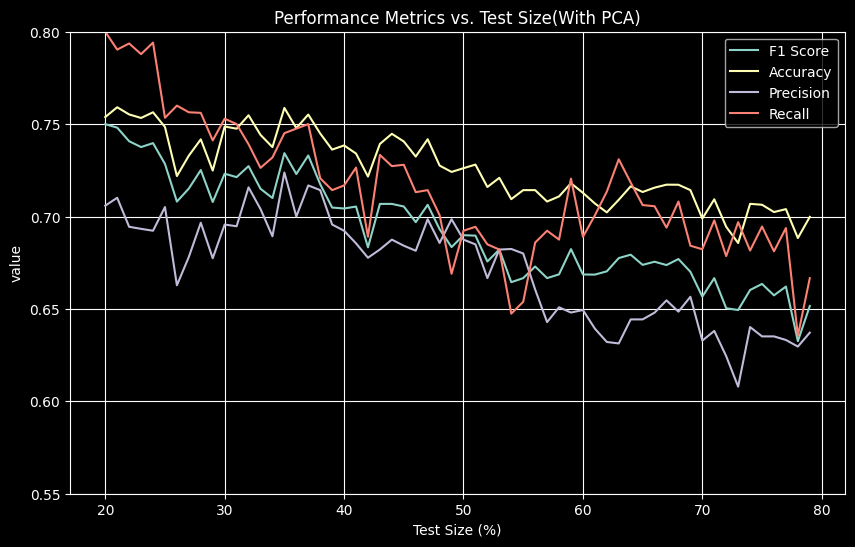

In [22]:
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
plt.plot(log_df['Iteration'], log_df['F1 Score'], label='F1 Score')
plt.plot(log_df['Iteration'], log_df['Accuracy'], label='Accuracy')
plt.plot(log_df['Iteration'], log_df['Precision'], label='Precision')
plt.plot(log_df['Iteration'], log_df['Recall'], label='Recall')

plt.xlabel('Test Size (%)')
plt.ylabel('value')
plt.title('Performance Metrics vs. Test Size(With PCA)')
plt.legend()
plt.grid(True)
plt.ylim(0.55, 0.8)
plt.savefig('../plots/../plots/pca_then_lr.png')

plt.show()